<a href="https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/EmoInt_Embedding_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install gensim

In [5]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

1.12.0


Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [5]:
# Import the Universal Sentence Encoder's TF Hub module
tf_use_embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [6]:
sentences = ["I love you so much", "I hate that movie, there are no plotline or even interesting scenes"]
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embedded_sentences = session.run(tf_use_embed(sentences))
    for i, embedded_sentence in enumerate(np.array(embedded_sentences).tolist()):
        print("Sentence: {}".format(sentences[i]))
        print("Embedding size: {}".format(len(embedded_sentence)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in embedded_sentence[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Sentence: I love you so much
Embedding size: 512
Embedding: [-0.03638805076479912, -0.07312509417533875, 0.007526352070271969, ...]

Sentence: I hate that movie, there are no plotline or even interesting scenes
Embedding size: 512
Embedding: [0.016185155138373375, 0.059069763869047165, -0.0056126900017261505, ...]



In [0]:
def embed_use(sentences):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embedded_sentences = session.run(tf_use_embed(sentences))
        return embedded_sentences

In [0]:
from pathlib import Path

class EmoIntDataset(object):
    BASE_URL = "http://saifmohammad.com/WebDocs/"
    TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
    TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
    EMOTION_CLASSES = ["anger", "fear", "joy", "sadness"]
    DATASET_NAME = "EmoInt"
  
    THRESHOLD = 0.33
  
    def __load_data_per_class(self, category, class_name, url, threshold=0):
        filename = "./{}_{}_{}.csv".format(category, self.DATASET_NAME, class_name)
        if Path(filename).is_file():
            df = pd.read_csv(filename)
        else:
            resource = urllib.request.urlopen(url)
            np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
            df = pd.DataFrame(np_array, columns=["id", "text", "emotion", "emotion_level"])
            df['emotion_level'] = df['emotion_level'].astype(float)
            df = df.query('emotion_level>' + str(threshold))
            df.to_csv(filename, index=False)
        return df[["text", "emotion"]]
  
    def load_data(self, set_threshold=False):
        train_data = None
        test_data = None
    
        for emotion in self.EMOTION_CLASSES:
            # load train dataset
            train_df = self.__load_data_per_class("train", emotion, self.BASE_URL + self.TRAIN_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
            # load test dataset
            test_df = self.__load_data_per_class("test", emotion, self.BASE_URL + self.TEST_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
            train_data = (train_df if train_data is None else train_data.append(train_df))
            test_data = (test_df if test_data is None else test_data.append(test_df))
      
        return train_data, test_data

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [8]:
emo_int_dataset = EmoIntDataset()
train_data, test_data = emo_int_dataset.load_data(set_threshold=True)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2610, 2)
(291, 2)
(2508, 2)


In [9]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'fear': 0, 'anger': 1, 'sadness': 2, 'joy': 3}
['fear', 'anger', 'sadness', 'joy']


In [0]:
train_labels = np.array(train_data.emotion.apply(lambda x:dic[x]))
test_labels = np.array(test_data.emotion.apply(lambda x:dic[x]))

# Embed with Universal Sentence Encoder

In [0]:
train_embedded_use = embed_use(train_data.text.tolist())
test_embedded_use = embed_use(test_data.text.tolist())

# Universal Sentence Encoder + SVM Classifier

In [13]:
from sklearn import svm
clfSVM = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clfSVM.fit(train_embedded_use, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
test_pred_labels = clfSVM.predict(test_embedded_use)

In [15]:
cmSVM = confusion_matrix(test_labels, test_pred_labels)
cmSVM

array([[548, 108,  86,  47],
       [137, 415,  62,  29],
       [141,  63, 291,  38],
       [ 54,  36,  45, 408]])

In [0]:
print(print_confusion_matrix(cmSVM, class_names=labels))

In [16]:
reportSVM = classification_report(test_labels, test_pred_labels, target_names=labels)
print(reportSVM)

             precision    recall  f1-score   support

       fear       0.62      0.69      0.66       789
      anger       0.67      0.65      0.66       643
    sadness       0.60      0.55      0.57       533
        joy       0.78      0.75      0.77       543

avg / total       0.66      0.66      0.66      2508



# TfIdfVectorizer + SVM Classifier

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=70, min_df=2, ngram_range=(1, 3))
train_tfidf_vectors = tfidf_vectorizer.fit_transform(train_data.text.tolist())
test_tfidf_vectors = tfidf_vectorizer.transform(test_data.text.tolist())

In [14]:
from sklearn import svm
clf_SVM_Tfidf = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_SVM_Tfidf.fit(train_tfidf_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
test_pred_labels_Tfidf = clf_SVM_Tfidf.predict(test_tfidf_vectors)

In [16]:
cmSVM_Tfidf = confusion_matrix(test_labels, test_pred_labels_Tfidf)
cmSVM_Tfidf

array([[625,  47,  89,  28],
       [ 82, 497,  46,  18],
       [ 94,  34, 392,  13],
       [ 53,  15,  21, 454]])

In [0]:
print(print_confusion_matrix(cmSVM_Tfidf, class_names=labels))

In [17]:
reportSVM = classification_report(test_labels, test_pred_labels_Tfidf, target_names=labels)
print(reportSVM)

             precision    recall  f1-score   support

       fear       0.73      0.79      0.76       789
      anger       0.84      0.77      0.80       643
    sadness       0.72      0.74      0.73       533
        joy       0.88      0.84      0.86       543

avg / total       0.79      0.78      0.79      2508



# CountVectorizer + SVM Classifier

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', 
                                   ngram_range=(1, 3), max_df=70, min_df=2, max_features=None)

train_count_vectors = count_vectorizer.fit_transform(train_data.text.tolist())
test_count_vectors = count_vectorizer.transform(test_data.text.tolist())

clf_NB_count = MultinomialNB(alpha=0.1)
clf_SVM_count = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_NB_count.fit(train_count_vectors, train_labels)
clf_SVM_count.fit(train_count_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
# get the feature names as numpy array
feature_names = np.array(count_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = clf_NB_count.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['00' 'ly broadcast paulzimmer' 'ly broadcast mrgummyking'
 'ly broadcast maisiev' 'ly broadcast kaylaaa_sartorious'
 'ly broadcast katyy' 'ly broadcast kana_blender'
 'ly broadcast jaredhorgan' 'ly broadcast rosannahill'
 'ly broadcast izzybuzy365']

Largest Coefs: 
['terrorism' 'fear' 'nightmare' 'terrible' 'awful' 'terror' 'nervous'
 'horror' 'panic' 'anxiety']


In [20]:
test_pred_labels_count = clf_SVM_count.predict(test_count_vectors)

cmSVM_count = confusion_matrix(test_labels, test_pred_labels_count)
cmSVM_count

array([[644,  37,  92,  16],
       [ 65, 516,  53,   9],
       [ 76,  32, 409,  16],
       [ 56,  13,  26, 448]])

Figure(288x216)


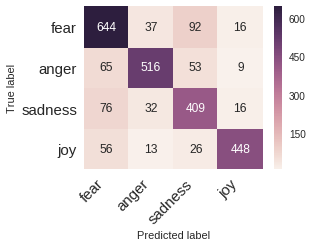

In [32]:
print(print_confusion_matrix(cmSVM_count, class_names=labels))

In [21]:
reportSVM = classification_report(test_labels, test_pred_labels_count, target_names=labels)
print(reportSVM)

             precision    recall  f1-score   support

       fear       0.77      0.82      0.79       789
      anger       0.86      0.80      0.83       643
    sadness       0.71      0.77      0.73       533
        joy       0.92      0.83      0.87       543

avg / total       0.81      0.80      0.81      2508



# CV 5 fold with CountVectorizer + TfIdfTransformer + SVM Classifier 

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__C': (10000.0,),
    'clf__gamma': ('auto',),
    'clf__kernel': ('rbf',),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(train_data.text.tolist(), train_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tfidf__use_idf': (True, False), 'clf__C': (10000.0,), 'clf__gamma': ('auto',), 'clf__kernel': ('rbf',)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [23]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.832
Best parameters set:
	clf__C: 10000.0
	clf__gamma: 'auto'
	clf__kernel: 'rbf'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [24]:
test_pred_labels_grid = grid_search.predict(test_data.text.tolist())

cmSVM_grid = confusion_matrix(test_labels, test_pred_labels_grid)
cmSVM_grid

array([[630,  49,  86,  24],
       [ 85, 483,  57,  18],
       [ 89,  41, 387,  16],
       [ 49,  18,  21, 455]])

Figure(288x216)


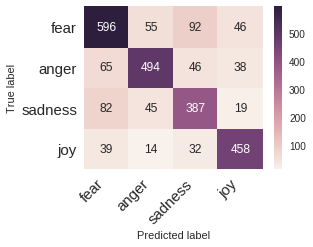

In [33]:
print(print_confusion_matrix(cmSVM_grid, class_names=labels))

In [25]:
reportSVM_grid = classification_report(test_labels, test_pred_labels_grid, target_names=labels)
print(reportSVM_grid)

             precision    recall  f1-score   support

       fear       0.74      0.80      0.77       789
      anger       0.82      0.75      0.78       643
    sadness       0.70      0.73      0.71       533
        joy       0.89      0.84      0.86       543

avg / total       0.78      0.78      0.78      2508



# CV 5 fold with CountVectorizer + TfIdfTransformer + SGDClassifier 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(train_data.text.tolist(), train_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [27]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.828
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 5
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


In [28]:
train_pred_labels_grid = grid_search.predict(train_data.text.tolist())

cmSVM_grid = confusion_matrix(train_labels, train_pred_labels_grid)
cmSVM_grid

array([[814,   2,   7,   0],
       [  0, 652,   7,   0],
       [  7,   4, 545,   0],
       [  0,   0,   0, 572]])

In [29]:
test_pred_labels_grid = grid_search.predict(test_data.text.tolist())

cmSVM_grid = confusion_matrix(test_labels, test_pred_labels_grid)
cmSVM_grid

array([[596,  55,  92,  46],
       [ 65, 494,  46,  38],
       [ 82,  45, 387,  19],
       [ 39,  14,  32, 458]])

Figure(288x216)


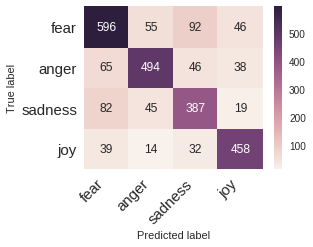

In [30]:
print(print_confusion_matrix(cmSVM_grid, class_names=labels))

In [31]:
reportSVM_grid = classification_report(test_labels, test_pred_labels_grid, target_names=labels)
print(reportSVM_grid)

             precision    recall  f1-score   support

       fear       0.76      0.76      0.76       789
      anger       0.81      0.77      0.79       643
    sadness       0.69      0.73      0.71       533
        joy       0.82      0.84      0.83       543

avg / total       0.77      0.77      0.77      2508



# spaCy vectorization + SVM Classifier

In [36]:
!python -m spacy download en_core_web_lg

    100% |████████████████████████████████| 852.3MB 31.5MB/s 
  Running setup.py install for en-core-web-lg ... - \ | / - \ | / - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
import spacy

nlp = spacy.load('en_core_web_lg')
train_spacy_vectors = train_data.text.apply(lambda x: nlp(x).vector).tolist()
test_spacy_vectors = test_data.text.apply(lambda x: nlp(x).vector).tolist()

In [38]:
clf_SVM_spacy = svm.SVC(C=10000.0, gamma='auto', kernel='rbf')
clf_SVM_spacy.fit(train_spacy_vectors, train_labels)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
test_pred_labels_spacy = clf_SVM_spacy.predict(test_spacy_vectors)

cmSVM_spacy = confusion_matrix(test_labels, test_pred_labels_spacy)
cmSVM_spacy

array([[536,  97, 113,  43],
       [117, 432,  74,  20],
       [138,  52, 308,  35],
       [ 49,  26,  41, 427]])

In [40]:
reportSVM_spacy = classification_report(test_labels, test_pred_labels_spacy, target_names=labels)
print(reportSVM_spacy)

             precision    recall  f1-score   support

       fear       0.64      0.68      0.66       789
      anger       0.71      0.67      0.69       643
    sadness       0.57      0.58      0.58       533
        joy       0.81      0.79      0.80       543

avg / total       0.68      0.68      0.68      2508



# Using spaCy TextCategorizer

In [41]:
labels

['fear', 'anger', 'sadness', 'joy']

In [42]:
from spacy.pipeline import TextCategorizer

model = 'en_core_web_lg'
nlp = spacy.load(model)  # load existing spaCy model
print("Loaded model '%s'" % model)

textcat = nlp.create_pipe('textcat')
nlp.add_pipe(textcat, last=True)

Loaded model 'en_core_web_lg'


In [43]:
# assign label
for label in labels:
    textcat.add_label(label)
    
textcat.labels

['fear', 'anger', 'sadness', 'joy']

In [0]:
train_texts = train_data.text.tolist()
valid_texts = valid_data.text.tolist()
test_texts = test_data.text.tolist()

train_labels = np.array(train_data.emotion.apply(lambda x:dic[x]))
valid_labels = np.array(valid_data.emotion.apply(lambda x:dic[x]))
test_labels = np.array(test_data.emotion.apply(lambda x:dic[x]))

In [0]:
def to_spacy_categorical(label_data, labels):
    new_data = dict()
    for label in labels:
        new_data[label] = (label_data == label)
    return new_data

In [0]:
train_encoded_labels = np.array(train_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))
valid_encoded_labels = np.array(valid_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))
test_encoded_labels = np.array(test_data.emotion.apply(lambda x:to_spacy_categorical(x, labels)))

In [47]:
train_encoded_labels

array([{'fear': True, 'anger': False, 'sadness': False, 'joy': False},
       {'fear': True, 'anger': False, 'sadness': False, 'joy': False},
       {'fear': False, 'anger': True, 'sadness': False, 'joy': False},
       ...,
       {'fear': False, 'anger': True, 'sadness': False, 'joy': False},
       {'fear': False, 'anger': False, 'sadness': False, 'joy': True},
       {'fear': False, 'anger': False, 'sadness': False, 'joy': True}],
      dtype=object)

In [0]:
train_spacy_data = list(zip(train_texts, [{'cats': cats} for cats in train_encoded_labels]))
valid_spacy_data = list(zip(valid_texts, [{'cats': cats} for cats in valid_encoded_labels]))
test_spacy_data = list(zip(test_texts, [{'cats': cats} for cats in test_encoded_labels]))

In [0]:
from spacy.util import minibatch

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


def training(spacy_nlp, train_data, valid_data, epoch=20):
    valid_texts, valid_labels = zip(*valid_data)
    
    other_pipes = [pipe for pipe in spacy_nlp.pipe_names if pipe != 'textcat']
    with spacy_nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = spacy_nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('EPOCH', 'LOSS', 'P', 'R', 'F'))
        for i in range(epoch):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=4)

            for batch in batches:
                texts, annotations = zip(*batch)
                spacy_nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)

            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(spacy_nlp.tokenizer, textcat, valid_texts, valid_labels)

            print('{0:.0f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(i + 1, losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    return spacy_nlp

In [0]:
nlp = training(nlp, train_spacy_data, valid_spacy_data, epoch=20)